# Predicting ratings of Google Play Store apps

## Importing libraries

We will be using the following libraries:

- numpy - for numerical computations
- pandas - for data structures and data analysis
- matplotlib - for plotting
- xgboost - for gradient boosting model
- sklearn - for GridSearchCV, mean_squared_error, and mean_absolute_error and other utility functions
- BorutaShap - for feature selection

```python

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from BorutaShap import BorutaShap

## Getting training and testing data

In [19]:
# Path to training and testing datasets
PATH_X_TRAIN = 'data/googleplaystore_X_train.csv'
PATH_Y_TRAIN = 'data/googleplaystore_y_train.csv'
PATH_X_TEST = 'data/googleplaystore_X_test.csv'
PATH_Y_TEST = 'data/googleplaystore_y_test.csv'

In [20]:
# Load training and testing datasets
X_train = pd.read_csv(PATH_X_TRAIN)
y_train = pd.read_csv(PATH_Y_TRAIN)
X_test = pd.read_csv(PATH_X_TEST)
y_test = pd.read_csv(PATH_Y_TEST)

In [21]:
# Encode categorical features using ordinal encoding
def ordinal_encoding(col):
    """Ordinal encoding for categorical features."""
    return OrdinalEncoder().fit_transform(col.values.reshape(-1, 1))

In [22]:
X_train['Category'] = pd.DataFrame(ordinal_encoding(X_train['Category']))
X_train['Type'] = pd.DataFrame(ordinal_encoding(X_train['Type']))
X_train['Content Rating'] = pd.DataFrame(ordinal_encoding(X_train['Content Rating']))
X_train['Primary Genre'] = pd.DataFrame(ordinal_encoding(X_train['Primary Genre']))
X_train['Secondary Genre'] = pd.DataFrame(ordinal_encoding(X_train['Secondary Genre']))

In [23]:
X_test['Category'] = pd.DataFrame(ordinal_encoding(X_test['Category']))
X_test['Type'] = pd.DataFrame(ordinal_encoding(X_test['Type']))
X_test['Content Rating'] = pd.DataFrame(ordinal_encoding(X_test['Content Rating']))
X_test['Primary Genre'] = pd.DataFrame(ordinal_encoding(X_test['Primary Genre']))
X_test['Secondary Genre'] = pd.DataFrame(ordinal_encoding(X_test['Secondary Genre']))

In [24]:
X_train

,Category,Reviews,Size,Installs,Type,Price,Content Rating,Primary Genre,Secondary Genre
0,6.0,-0.157740,0.453740,10.0,0.0,-0.062993,1.0,13.0,NaN
1,11.0,-0.080897,-0.728124,14.0,0.0,-0.062993,1.0,17.0,4.0
2,8.0,-0.154967,-0.022469,12.0,0.0,-0.062993,3.0,15.0,NaN
3,26.0,-0.139815,-0.455386,12.0,0.0,-0.062993,1.0,37.0,NaN
4,29.0,-0.090800,-0.875315,14.0,0.0,-0.062993,1.0,42.0,NaN
...,...,...,...,...,...,...,...,...,...
5934,11.0,-0.155384,-0.109052,12.0,0.0,-0.062993,1.0,38.0,NaN
5935,4.0,-0.158760,-0.065761,6.0,0.0,-0.062993,4.0,8.0,NaN
5936,9.0,-0.152189,-0.801720,12.0,0.0,-0.062993,1.0,17.0,NaN
5937,14.0,1.143622,2.791491,14.0,0.0,-0.062993,4.0,0.0,NaN


## Feature selection

We will be using all features for a model, then we will train another model based on the most important features. The most important features are determined by a technique called 'Boruta-SHAP'. This is partly because we cannot identify any important features that correlates with `Rating` (see preprocessing_and_eda for more information). We will then compare the performance of the two models.

## Regression using XGBoost

Feature selections: `Reviews`, `Size`, `Price`, `Category`, `Installs`, `Type`, `Content Rating`, `Primary Genre`, `Secondary Genre`

Response variable: `Rating`

Why XGBoost?

XGBoost is a form of Gradient Boosting, which is a machine learning technique for regression problems. It produces a prediction model by combining weak models, in this case the weak models are decision trees.

XGBoost is fast and accurate, and it can work with large datasets. It can perform well in datasets with outliers . It is also well suited for non-linear problems. These characteristics make it a good choice for this dataset, which is large, has outliers, and is non-linear.

In [25]:
# Regression using XGBoost

# Define XGBoost model
xgb_model = xgb.XGBRegressor(eval_metric='rmse')

# Cross-validation grid search for hyperparameter tuning for XGBoost model, 
# i.e. trying out different combinations of hyperparameters to find the best combination

# Define grid search parameters
param_grid = {
    'max_depth': [2, 3, 4, 5, 6],
    'learning_rate': [0.05, 0.1, 0.15],
    'n_estimators': [100, 200, 300, 400, 500]
}

# Perform grid search
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1).fit(X_train, y_train)

print("Optimal hyperparameters for XGBoost model: ", grid_search.best_params_)

Fitting 5 folds for each of 75 candidates, totalling 375 fits
Optimal hyperparameters for XGBoost model:  {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 300}


Cross-validation search for best parameters by trying out different combinations of parameters as specified in `param_grid`. The best parameters are then used to train the model.

In [26]:
# Build XGBoost model using optimal hyperparameters
xgb_model = xgb.XGBRegressor(   max_depth=grid_search.best_params_['max_depth'],
                                learning_rate=grid_search.best_params_['learning_rate'],
                                n_estimators=grid_search.best_params_['n_estimators'],
                                eval_metric='rmse').fit(X_train, y_train)

### Model evaluation

In [27]:
# Predict on test set

xgb_pred = xgb_model.predict(X_test)
mse = mean_squared_error(y_test, xgb_pred)
mae = mean_absolute_error(y_test, xgb_pred)
print("Mean Squared Error: ", mse)
print("Mean Absolute Error: ", mae)

Mean Squared Error:  2.4236993463504195
Mean Absolute Error:  1.2348376316173308


**Remarks:** The mean squared error (which is the main metric used throughout the project) of XGBoost is 2.42, which is significantly higher than results produced by DNN network and Random Forest model. MAE = 1.23, which can be intuited as the average difference between the predicted and actual ratings. This result is not very effective when predicting value on the scale of 1 - 5. It is therefore not recommended to use XGBoost for this task.

## XGBoost with feature selection

We will first try to select important features using Boruta-SHAP based on the previous model. Then we will train another model using the selected features. This way we may find features that are important to the gradient boosting model, assuming that the model hyperparameters are optimal.

**Note:** `BorutaShap` library requires an older version of `scikit-learn` (< 1.2). Using the latest version of `scikit-learn` will result in an error.

In [28]:
# Initialize a BorutaShap object
# classification = False because we are solving a regression problem

Feature_selection = BorutaShap(importance_measure='shap', classification=False, model=xgb_model)

Feature_selection.fit(X=X_train, y=y_train['Rating'], random_state=0, n_trials=100)

Warning there are missing values in your data !


100%|██████████| 100/100 [01:05<00:00,  1.53it/s]

5 attributes confirmed important: ['Category', 'Size', 'Reviews', 'Primary Genre', 'Installs']
4 attributes confirmed unimportant: ['Type', 'Content Rating', 'Price', 'Secondary Genre']
0 tentative attributes remains: []


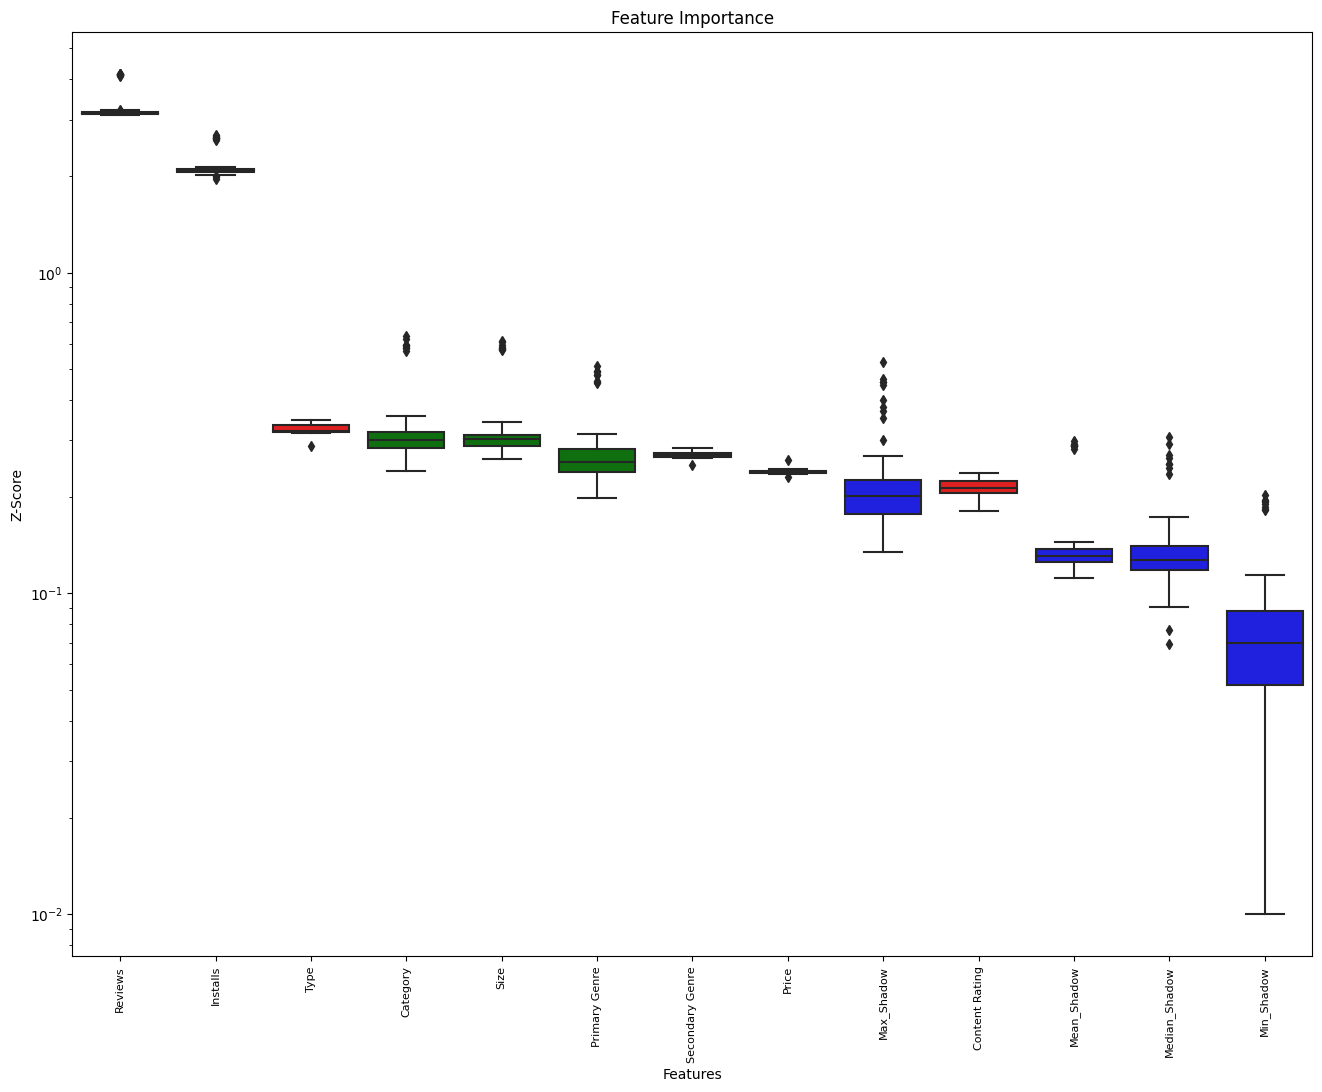

In [29]:
Feature_selection.plot(which_features='all', figsize=(16,12))

In [30]:
Feature_selection.Subset()

,Category,Size,Reviews,Primary Genre,Installs
0,6.0,0.453740,-0.157740,13.0,10.0
1,11.0,-0.728124,-0.080897,17.0,14.0
2,8.0,-0.022469,-0.154967,15.0,12.0
3,26.0,-0.455386,-0.139815,37.0,12.0
4,29.0,-0.875315,-0.090800,42.0,14.0
...,...,...,...,...,...
5934,11.0,-0.109052,-0.155384,38.0,12.0
5935,4.0,-0.065761,-0.158760,8.0,6.0
5936,9.0,-0.801720,-0.152189,17.0,12.0
5937,14.0,2.791491,1.143622,0.0,14.0


So, Boruta-SHAP algorithm suggests that the most important features are `Category`, `Size`, `Installs`, `Reviews`, `Primary Genre`. We will train another model using these features.

In [31]:
# Subset the training and testing datasets
X_train_subset = X_train[Feature_selection.Subset().columns]
X_test_subset = X_test[Feature_selection.Subset().columns]

### Training model

In [32]:
# Regression using XGBoost

# Define XGBoost model
xgb_model_subset = xgb.XGBRegressor(eval_metric='rmse')

# Cross-validation grid search for hyperparameter tuning for XGBoost model, 
# i.e. trying out different combinations of hyperparameters to find the best combination

# Define grid search parameters
param_grid = {
    'max_depth': [2, 3, 4, 5, 6],
    'learning_rate': [0.05, 0.1, 0.15],
    'n_estimators': [100, 200, 300, 400, 500]
}

# Perform grid search
grid_search_subset = GridSearchCV(estimator=xgb_model_subset, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1).fit(X_train_subset, y_train)

print("Optimal hyperparameters for XGBoost model: ", grid_search_subset.best_params_)

Fitting 5 folds for each of 75 candidates, totalling 375 fits
Optimal hyperparameters for XGBoost model:  {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 300}


In [33]:
# Build XGBoost model using optimal hyperparameters
xgb_model_subset = xgb.XGBRegressor(   max_depth=grid_search_subset.best_params_['max_depth'],
                                learning_rate=grid_search_subset.best_params_['learning_rate'],
                                n_estimators=grid_search_subset.best_params_['n_estimators'],
                                eval_metric='rmse').fit(X_train_subset, y_train)

### Model evaluation

In [34]:
# Predict on test set

xgb_subset_pred = xgb_model_subset.predict(X_test_subset)
mse = mean_squared_error(y_test, xgb_subset_pred)
mae = mean_absolute_error(y_test, xgb_subset_pred)
print("Mean Squared Error: ", mse)
print("Mean Absolute Error: ", mae)

Mean Squared Error:  2.3110729193499675
Mean Absolute Error:  1.2061752249656703


**Remarks:** There is no significant improvement in the mean squared error and mean absolute error after feature selection. We think that by providing the model with insufficient features, the model does not capture the complex hidden relationships at play between less important, but still impactful, variables. After all, we are cutting the number of features to only 5, which means a lot of good hidden indicators of rating will also be discarded.

This model is therefore not recommended for predicting ratings of Google Play Store apps.